<a href="https://colab.research.google.com/github/karnigili/NetworksNeuroscience/blob/master/rs_fmri_LSTM_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#%pip install nilearn
from nilearn import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from nilearn.input_data import NiftiMapsMasker
from nilearn import plotting

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.layers import LSTM
from keras import optimizers
from keras.utils import plot_model


from keras import utils


from scipy.stats import ttest_1samp
from scipy import interp
from sklearn.metrics import roc_curve



## Preparing data for analysis ##

Import data, and exctract features

In [0]:
## load the smith (ICA based) mask
## 'rsn10': 10 ICA maps from the above that matched across task and rest
# http://brainmap.org/pubs/SmithPNAS09.pdf

smith_atlas = datasets.fetch_atlas_smith_2009()
smith_atlas_rs_networks = smith_atlas.rsn70


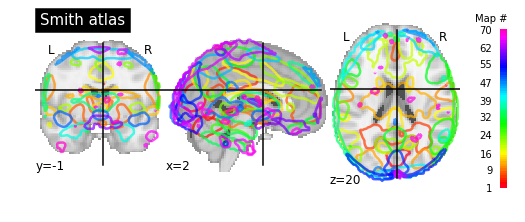

In [0]:
plotting.plot_prob_atlas(smith_atlas_rs_networks, 
                         title='Smith atlas',  
                         colorbar=True)
plotting.show()

In [0]:
# Import preprocessed, ready-to-go, datasets
adhd_data=datasets.fetch_adhd(n_subjects=100)


Dataset created in /Users/gilikarni/nilearn_data/adhd



Downloaded 3072 of 3072 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/74a52d3552145e11365bb68453d1a70c/adhd40_metadata.tgz..... done.


Downloaded 44414948 of 44414948 bytes (100.0%,    0.0s remaining) ...done. (67 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0010042.tgz..... done.


Downloaded 45583539 of 45583539 bytes (100.0%,    0.0s remaining) ...done. (47 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0010064.tgz..... done.


Downloaded 45461055 of 45461055 bytes (100.0%,    0.0s remaining) ...done. (58 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0010128.tgz..... done.


Downloaded 46216320 of 46216320 bytes (100.0%,    0.0s remaining) ...done. (41 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0021019.tgz..... done.


Downloaded 20407901 of 20407901 bytes (100.0%,    0.0s remaining) ...done. (29 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0023008.tgz..... done.


Downloaded 20706939 of 20706939 bytes (100.0%,    0.0s remaining) ...done. (53 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0023012.tgz..... done.


Downloaded 72402326 of 72402326 bytes (100.0%,    0.0s remaining) ...done. (88 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0027011.tgz..... done.


Downloaded 76184603 of 76184603 bytes (100.0%,    0.0s remaining) ...done. (71 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0027018.tgz..... done.


Downloaded 70074120 of 70074120 bytes (100.0%,    0.0s remaining) ...done. (129 seconds, 2 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0027034.tgz..... done.


Downloaded 69291635 of 69291635 bytes (100.0%,    0.0s remaining) ...done. (79 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_0027037.tgz..... done.


Downloaded 41803342 of 41803342 bytes (100.0%,    0.0s remaining) ...done. (68 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_1019436.tgz..... done.


Downloaded 20763649 of 20763649 bytes (100.0%,    0.0s remaining) ...done. (31 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_1206380.tgz..... done.


Downloaded 20168043 of 20168043 bytes (100.0%,    0.0s remaining) ...done. (24 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_1418396.tgz..... done.


Downloaded 62682233 of 62682233 bytes (100.0%,    0.0s remaining) ...done. (60 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_1517058.tgz..... done.


Downloaded 20196558 of 20196558 bytes (100.0%,    0.0s remaining) ...done. (43 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_1552181.tgz..... done.


Downloaded 60663491 of 60663491 bytes (100.0%,    0.0s remaining) ...done. (54 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_1562298.tgz..... done.


Downloaded 20628764 of 20628764 bytes (100.0%,    0.0s remaining) ...done. (26 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_1679142.tgz..... done.


Downloaded 33119052 of 33119052 bytes (100.0%,    0.0s remaining) ...done. (38 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_2014113.tgz..... done.


Downloaded 45455025 of 45455025 bytes (100.0%,    0.0s remaining) ...done. (28 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_2497695.tgz..... done.


Downloaded 57992968 of 57992968 bytes (100.0%,    0.0s remaining) ...done. (53 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_2950754.tgz..... done.


Downloaded 67925261 of 67925261 bytes (100.0%,    0.0s remaining) ...done. (71 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3007585.tgz..... done.


Downloaded 32919780 of 32919780 bytes (100.0%,    0.0s remaining) ...done. (31 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3154996.tgz..... done.


Downloaded 59835286 of 59835286 bytes (100.0%,    0.0s remaining) ...done. (57 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3205761.tgz..... done.


Downloaded 61857076 of 61857076 bytes (100.0%,    0.0s remaining) ...done. (80 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3520880.tgz..... done.


Downloaded 59385206 of 59385206 bytes (100.0%,    0.0s remaining) ...done. (46 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3624598.tgz..... done.


Downloaded 41518251 of 41518251 bytes (100.0%,    0.0s remaining) ...done. (50 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3699991.tgz..... done.


Downloaded 32108848 of 32108848 bytes (100.0%,    0.0s remaining) ...done. (25 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3884955.tgz..... done.


Downloaded 39415752 of 39415752 bytes (100.0%,    0.0s remaining) ...done. (32 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3902469.tgz..... done.


Downloaded 59297020 of 59297020 bytes (100.0%,    0.0s remaining) ...done. (42 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_3994098.tgz..... done.


Downloaded 20157314 of 20157314 bytes (100.0%,    0.0s remaining) ...done. (22 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_4016887.tgz..... done.


Downloaded 21375806 of 21375806 bytes (100.0%,    0.0s remaining) ...done. (24 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_4046678.tgz..... done.


Downloaded 69914913 of 69914913 bytes (100.0%,    0.0s remaining) ...done. (51 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_4134561.tgz..... done.


Downloaded 45506732 of 45506732 bytes (100.0%,    0.0s remaining) ...done. (30 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_4164316.tgz..... done.


Downloaded 32363673 of 32363673 bytes (100.0%,    0.0s remaining) ...done. (24 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_4275075.tgz..... done.


Downloaded 73484949 of 73484949 bytes (100.0%,    0.0s remaining) ...done. (87 seconds, 1 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_6115230.tgz..... done.


Downloaded 42188959 of 42188959 bytes (100.0%,    0.0s remaining) ...done. (46 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_7774305.tgz..... done.


Downloaded 70396354 of 70396354 bytes (100.0%,    0.0s remaining) ...done. (55 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_8409791.tgz..... done.


Downloaded 45075978 of 45075978 bytes (100.0%,    0.0s remaining) ...done. (52 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_8697774.tgz..... done.


Downloaded 63380505 of 63380505 bytes (100.0%,    0.0s remaining) ...done. (53 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_9744150.tgz..... done.


Downloaded 46607053 of 46607053 bytes (100.0%,    0.0s remaining) ...done. (46 seconds, 0 min)
Extracting data from /Users/gilikarni/nilearn_data/adhd/166bfb3ae13f7c60c012aa2194eef088/adhd40_9750701.tgz..... done.


In [0]:
# exploring the header of one image 
import nibabel as nib
img=nib.load(adhd_data['func'][0])

print(img.header['dim'])
print(img.header['pixdim'])


[  4  61  73  61 176   1   1   1]
[-1.  3.  3.  3.  2.  0.  0.  0.]


In [0]:
# Region signals extraction- exctract the values of the ten networks

masker = NiftiMapsMasker(maps_img=smith_atlas_rs_networks,  # Smith stals
                         standardize=True, # centers and norms the time-series
                         memory='nilearn_cache', # cache
                         verbose=0) #do not print verbose

In [0]:
all_subjects_data=[]
labels=[]  # 1 if ADHD, 0 if control

for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    
    all_subjects_data.append(time_series)
    labels.append(phenotypic['adhd'])


In [0]:
print('N control:' ,labels.count(0))
print('N adhd:' ,labels.count(1))

N control: 20
N adhd: 20


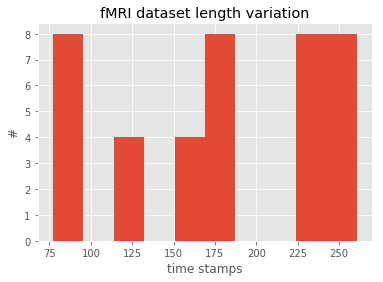

In [0]:
plt.hist([len(i) for i in all_subjects_data])
plt.title('fMRI dataset length variation')
plt.xlabel('time stamps')
plt.ylabel('#')
plt.show()

In [0]:
# find the longest image
max_len_image=np.max([len(i) for i in all_subjects_data])


In [0]:
# reshape 

all_subjects_data_reshaped=[]
for subject_data in all_subjects_data:
  # Padding
  N= max_len_image-len(subject_data)
  padded_array=np.pad(subject_data, ((0, N), (0,0)), 
                      'constant', constant_values=(0))
  subject_data=padded_array
  subject_data=np.array(subject_data)
  subject_data.reshape(subject_data.shape[0],subject_data.shape[1],1)
  all_subjects_data_reshaped.append(subject_data)


In [0]:
# shape of data

# 40 subjects
# 261 time stamps
# 10 netwroks values

np.array(all_subjects_data_reshaped).shape

(40, 261, 70)

In [0]:
# The data, split between train and test sets.

def get_train_test(X, y, i, verbrose=False):
  '''
  split to train and test and reshape data
  X data
  y labels
  i random state
  '''
  X_train, X_test, y_train, y_test = train_test_split(X,
                                        y, test_size=0.2, random_state=i)



  # Reshapes data to 4D for Hierarchical RNN.
  t_shape=np.array(all_subjects_data_reshaped).shape[1]
  RSN_shape=np.array(all_subjects_data_reshaped).shape[2]
  
  X_train = np.reshape(X_train, (len(X_train), t_shape, RSN_shape))
  X_test = np.reshape(X_test, (len(X_test), t_shape, RSN_shape))

  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')

  if verbrose:
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
  
  # Converts class vectors to binary class matrices.
  y_train = utils.to_categorical(y_train, 2)
  y_test = utils.to_categorical(y_test, 2)
  
  return X_train, X_test, y_train, y_test



32 train samples
8 test samples


In [0]:
# create the model

model = Sequential()

# LSTM layers - 
# Long Short-Term Memory layer - Hochreiter 1997.
t_shape=np.array(all_subjects_data_reshaped).shape[1]
RSN_shape=np.array(all_subjects_data_reshaped).shape[2]

model.add(LSTM(units=70, # dimensionality of the output space 
               dropout=0.4, # Fraction of the units to drop (inputs)
               recurrent_dropout=0.15, # Fraction of the units to drop (recurent state)
               return_sequences=True, # return the last state in addition to the output
               input_shape=(t_shape,RSN_shape)))

model.add(LSTM(units=60,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=True))

model.add(LSTM(units=50,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=True))

model.add(LSTM(units=40,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=False))


model.add(Dense(units=2, 
                activation="sigmoid"))

model.compile(loss='binary_crossentropy', 
                optimizer=optimizers.Adam(lr=0.001), 
                metrics=['binary_accuracy'])

print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 261, 70)           39480     
_________________________________________________________________
lstm_2 (LSTM)                (None, 261, 60)           31440     
_________________________________________________________________
lstm_3 (LSTM)                (None, 261, 50)           22200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 40)                14560     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82        
Total params: 107,762
Trainable params

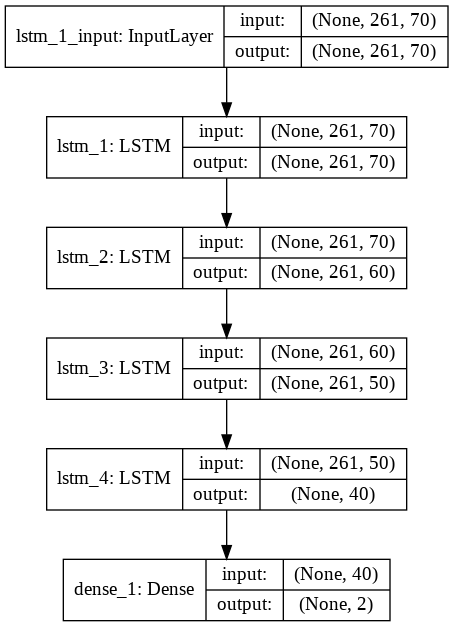

In [0]:
plot_model(model, show_shapes=True, show_layer_names=True)


32 train samples
8 test samples
Train on 25 samples, validate on 7 samples
Epoch 1/30
25/25 [==============================] - 2s 100ms/step - loss: 0.6885 - binary_accuracy: 0.5600 - val_loss: 0.6926 - val_binary_accuracy: 0.5714
Epoch 2/30
25/25 [==============================] - 1s 24ms/step - loss: 0.6929 - binary_accuracy: 0.5800 - val_loss: 0.6925 - val_binary_accuracy: 0.5714
Epoch 3/30
25/25 [==============================] - 1s 24ms/step - loss: 0.6929 - binary_accuracy: 0.5800 - val_loss: 0.6921 - val_binary_accuracy: 0.5714
Epoch 4/30
25/25 [==============================] - 1s 23ms/step - loss: 0.6881 - binary_accuracy: 0.6000 - val_loss: 0.6919 - val_binary_accuracy: 0.5714
Epoch 5/30
25/25 [==============================] - 1s 25ms/step - loss: 0.6813 - binary_accuracy: 0.6200 - val_loss: 0.6914 - val_binary_accuracy: 0.5714
Epoch 6/30
25/25 [==============================] - 1s 24ms/step - loss: 0.6774 - binary_accuracy: 0.6200 - val_loss: 0.6905 - val_binary_accuracy: 0

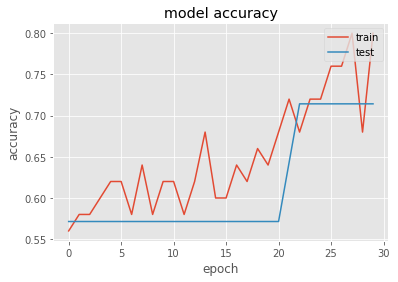

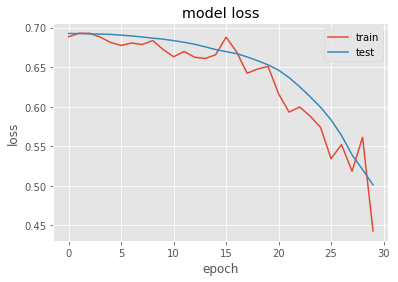

In [0]:
X_train, X_test, y_train, y_test = get_train_test(all_subjects_data_reshaped,
                                                    labels, i=8, verbrose=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30)

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [0]:
from sklearn.metrics import accuracy_score

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_subjects_data_reshaped,
                                              labels, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, validation_split=0.2, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr 



accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr  = boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test)

fitting..
Train on 25 samples, validate on 7 samples
Epoch 1/50
25/25 [==============================] - 1s 31ms/step - loss: 0.6721 - binary_accuracy: 0.5200 - val_loss: 0.6196 - val_binary_accuracy: 0.8571
Epoch 2/50
25/25 [==============================] - 1s 27ms/step - loss: 0.6737 - binary_accuracy: 0.4600 - val_loss: 0.6170 - val_binary_accuracy: 0.8571
Epoch 3/50
25/25 [==============================] - 1s 23ms/step - loss: 0.6482 - binary_accuracy: 0.6200 - val_loss: 0.6151 - val_binary_accuracy: 0.8571
Epoch 4/50
25/25 [==============================] - 1s 30ms/step - loss: 0.6489 - binary_accuracy: 0.5800 - val_loss: 0.6145 - val_binary_accuracy: 0.8571
Epoch 5/50
25/25 [==============================] - 1s 36ms/step - loss: 0.6650 - binary_accuracy: 0.6000 - val_loss: 0.6156 - val_binary_accuracy: 0.8571
Epoch 6/50
25/25 [==============================] - 1s 22ms/step - loss: 0.6448 - binary_accuracy: 0.6000 - val_loss: 0.6178 - val_binary_accuracy: 0.8571
Epoch 7/50
25/25 

In [0]:
def calc_p_val(stats, h0, n_iterations):
  '''
  finds the p value for the results 
  
  '''
  # calc pval
  tset, pval = ttest_1samp(stats, h0)

  return pval

p_val=calc_p_val(accuracy, .5)

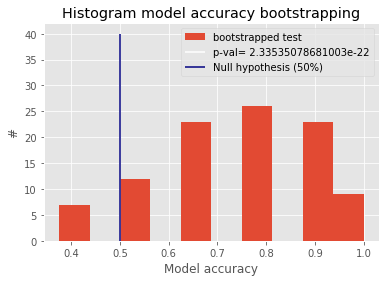

In [0]:
def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats, label='bootstrapped test')
  plt.vlines(.5, 0, 40, color='white', label='p-val= {}'.format(p_val))
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')

  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()

plot_p_value(accuracy, p_val)

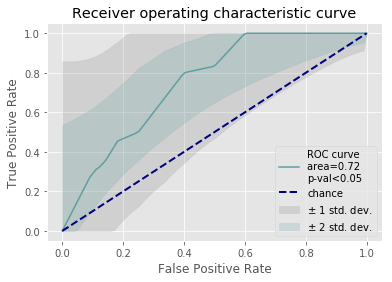

In [0]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)